In [97]:
import numpy as np
import pandas as pd
from itertools import product

test data creators

In [2]:
def matrix_creator(states_number):
    mat = np.random.rand(states_number, states_number)
    row_sums = mat.sum(axis=1)
    P = mat / row_sums[:, np.newaxis]
    return P

In [3]:
def observations_creator_stationary(P,n,starting_state, states_number):
    observations = [starting_state]
    for i in range(n):
            observations.append(np.random.choice(states_number,p=P[observations[i]]))
    return observations
            

In [4]:
def matrix_sequence(n_matrixes, states_number, duration):
    seq = []
    for i in range(n_matrixes):
        mat = matrix_creator(states_number)
        for j in range(np.random.choice(duration)): seq.append(mat)
    return seq

In [5]:
def observations_creator(seq,num_steps,starting_state, states_number):
    observations = [starting_state]
    for i in range(num_steps):
            observations.append(np.random.choice(states_number,p=seq[i][observations[i]]))
    return observations
            

In [8]:
def matrix_path(start, end, speed_func, num_steps):
    v = end-start
    path = []
    for t in range(num_steps+1):
        path.append(start+speed_func(t/num_steps)*v)
    return path

path = matrix_path(matrix_creator(2),matrix_creator(2),lambda x: x, 5 )
path    

[array([[0.47608708, 0.52391292],
        [0.61897861, 0.38102139]]),
 array([[0.39510685, 0.60489315],
        [0.54566387, 0.45433613]]),
 array([[0.31412663, 0.68587337],
        [0.47234912, 0.52765088]]),
 array([[0.2331464 , 0.7668536 ],
        [0.39903437, 0.60096563]]),
 array([[0.15216618, 0.84783382],
        [0.32571962, 0.67428038]]),
 array([[0.07118595, 0.92881405],
        [0.25240487, 0.74759513]])]

In [41]:
alphas = np.random.rand(3) 
a = np.random.default_rng().dirichlet(np.array(alphas), 3)
alphas, a

(array([0.87653869, 0.84030474, 0.61244941]),
 array([[0.94381696, 0.03432234, 0.02186069],
        [0.03762653, 0.62244508, 0.33992839],
        [0.35256794, 0.29579449, 0.35163757]]))

In [75]:
P = matrix_creator(3)
obs = observations_creator_stationary(P, 10, 0 , 3)
P, obs

(array([[0.43289211, 0.13602342, 0.43108447],
        [0.05170191, 0.10738812, 0.84090997],
        [0.50339156, 0.45234046, 0.04426797]]),
 [[0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0], 7.817458992107203e-05])

In [24]:
seq = matrix_sequence(4,2,10)
obs = observations_creator(seq, 9, 0, 2)
obs

[[0, 1, 1, 0, 0, 1, 1, 1, 0, 1], 0.005236358860606731]

functions for estimation

In [9]:
def distance(A,B):
    return np.sum((A-B)**2)

In [10]:
def func1(x): 
    return np.exp(-4*x)
def func2(x):
    return np.exp((-4)*(x**2))
def func3(x):
    if x < 1: return np.exp(1/(x**2-1))
    else: return 0
def func4(x):
    a = 1-x
    if a<0: return 0
    else: return a
def func5(x):
    if x>1: return 0
    else: return 1

In [11]:
def estimator(func, step, obs, states_number):
    P=np.zeros((states_number,states_number))
    for i in range(states_number):
        sums = np.zeros(states_number)
        quot = 0
        num =len(obs)
        for t in range(num-1):
            if obs[t] == i:
                quot += func(1-t*step/num)
                sums[obs[t+1]] += func(1-t*step/num)

        if quot!= 0: P[i] = sums/quot
    return P

sliding window estimation

In [95]:
def prob(i,j, size , window):
    p = 0
    for k in range(size):
        try:
            if window[k] == j: p+=1
        except: break
    return p/size

In [121]:
def sliding_window(obs, states_number, sizes_number, step, min_size):
    prob_windows = np.empty((states_number,states_number,sizes_number),dtype=object)
    windows = np.empty(states_number, dtype=object)
    for set_of_nums in product(range(states_number), range(states_number), range(sizes_number)): 
        i, j, k = set_of_nums
        windows[i] = []
        prob_windows[i][j][k] = []
                
    matrix = np.zeros((states_number,states_number))

    for t in range(1 , len(obs)-1, 1):
        i , j = obs[t-1], obs[t]
        windows[i].insert(0, j)
        for k in range(sizes_number):
            current_size =  min_size+step*k
            proba = prob(i,j,current_size , windows[i])
            prob_windows[i][j][k].insert(0, proba)


    for set_of_nums in product(range(states_number), range(states_number)): 
        i, j = set_of_nums
        try:
            matrix[i][j] = prob_windows[i][j][sizes_number-1][0]
        except: pass
        for k in range(sizes_number):      
            current_size = min(min_size+step*k, len(prob_windows[i][j][k]))
            est_var = sum(prob_windows[i][j][k][0:current_size:])/current_size
            est_var = (((np.array(prob_windows[i][j][k]) - est_var)**2)[0:current_size:].sum())/(current_size -1)
            ac_var = (prob_windows[i][j][k][0]*(1 -  prob_windows[i][j][k][0]))/ current_size 
            if est_var > ac_var:
                matrix[i][j] = prob_windows[i][j][k][0]
                break
    return matrix 

In [122]:
a,b = matrix_creator(4),matrix_creator(4)
path = matrix_path(a,b,lambda x: x, 10000 )
for j in range(1000): path.append(path[-1])
obs = observations_creator(path, len(path), 0, 4)
P = sliding_window(obs, 4, 99, 110, 110 )
path[-1], P,distance(path[-1], p)

0.006007661417710785

basic estimation of stationary MC

In [22]:
P = matrix_creator(3)
obs = observations_creator_stationary(P, 1000, 0 , 3)
P2=estimator(func5, 1, obs, 3)
P2,P, distance(P2,P)

(array([[0.12012987, 0.84090909, 0.03896104],
        [0.35465116, 0.34883721, 0.29651163],
        [0.5       , 0.4375    , 0.0625    ]]),
 array([[0.09669576, 0.87193356, 0.03137068],
        [0.32205596, 0.34660047, 0.33134357],
        [0.4946899 , 0.44048561, 0.06482449]]),
 0.0038925179178024333)

In [23]:
seq = matrix_sequence(10,5,10000)
obs = observations_creator(seq, len(seq), 0, 5)
dist = []
for func in [func1,func2,func3,func4,func5]:
    dist.append(distance(seq[-1], estimator(func,1, obs,len(seq[-1][0]))))
    
dist

[0.39314336464810723,
 0.4409856158332005,
 0.43241623944313456,
 0.4246490394598988,
 0.40883083673261694]

In [79]:
path = matrix_path(matrix_creator(3),matrix_creator(3),lambda x: x, 10000 )
for j in range(20000): path.append(path[-1])
obs = observations_creator(path, len(path), 0, 3)
dist = []
for func in [func1,func2,func3,func4,func5]:
    dist.append(distance(seq[-1], estimator(func,2/len(obs), obs,len(seq[-1][0]))))
    
dist

[1.0449760917786048,
 1.0383431380328765,
 1.0556271802207136,
 1.0564723281977402,
 1.036671517054432]

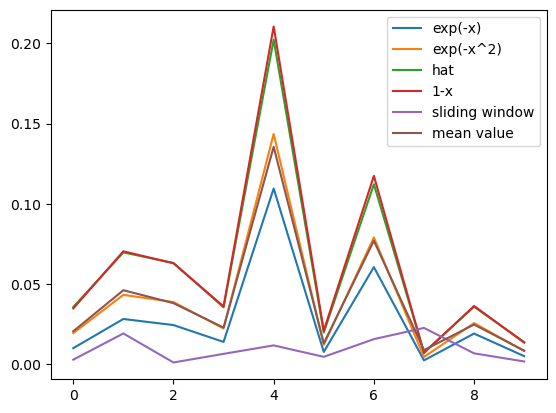

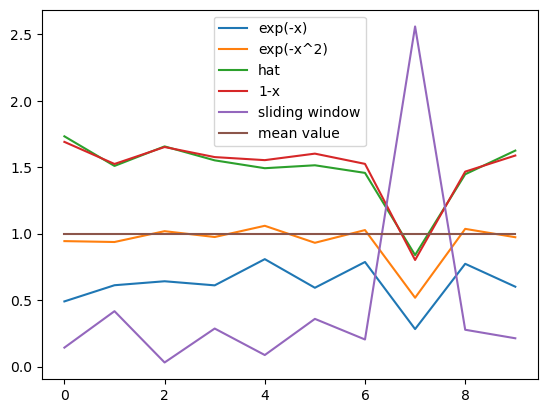

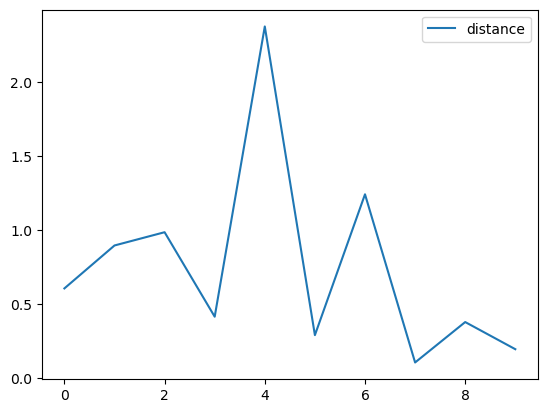

In [123]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 10000 )
    for j in range(1000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 110, 110 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

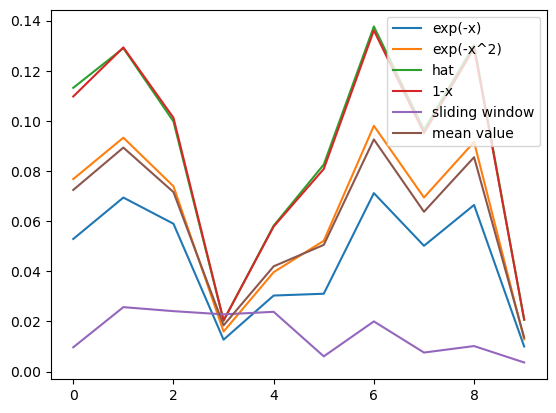

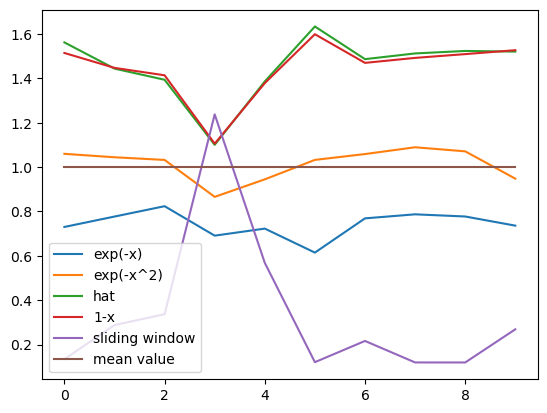

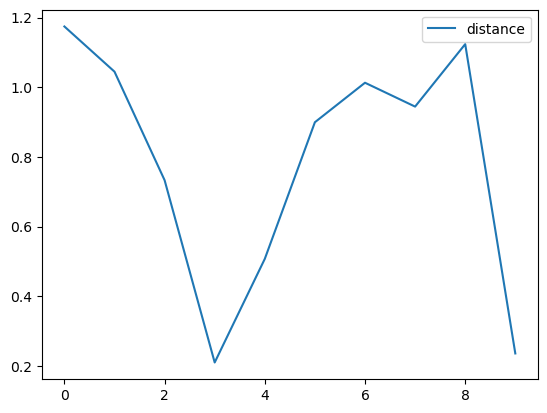

In [131]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 5000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 110, 110 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

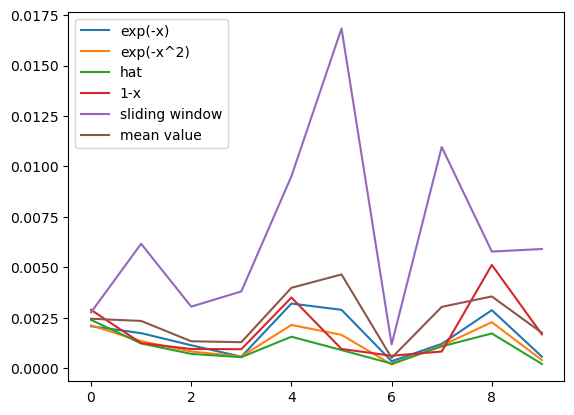

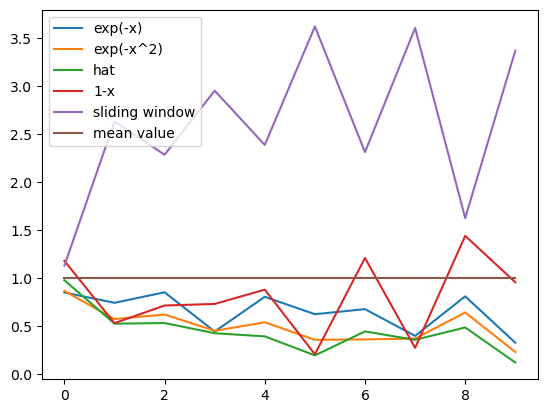

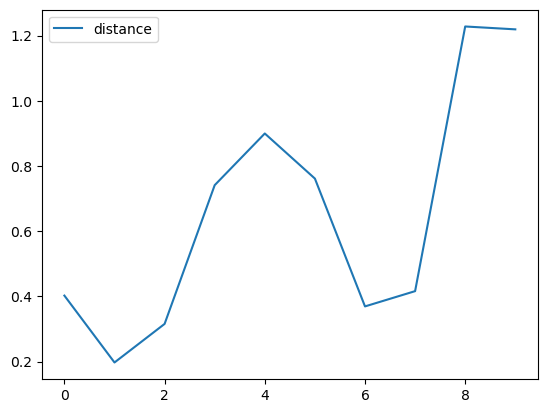

In [132]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 3000 )
    for j in range(6000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 90, 90 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

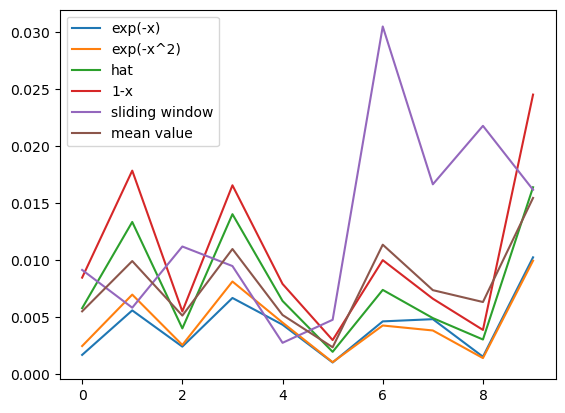

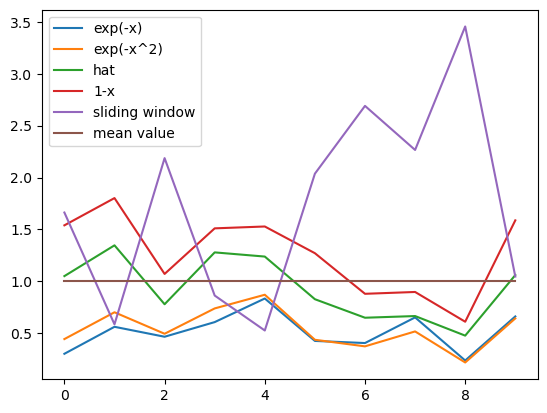

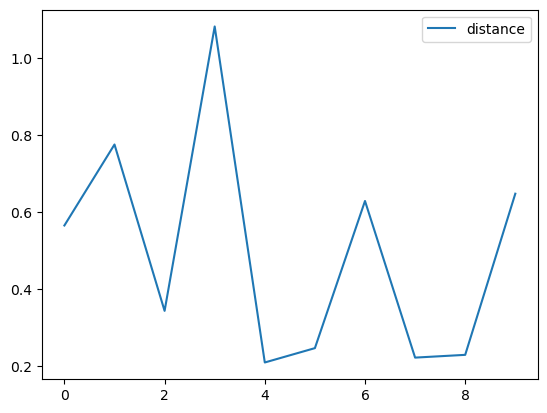

In [133]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**2, 3000 )
    for j in range(3000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 60, 60 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

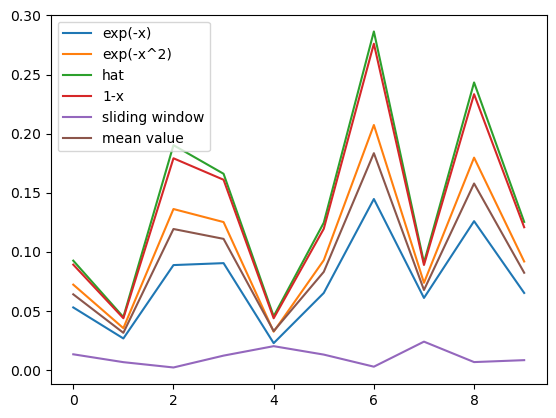

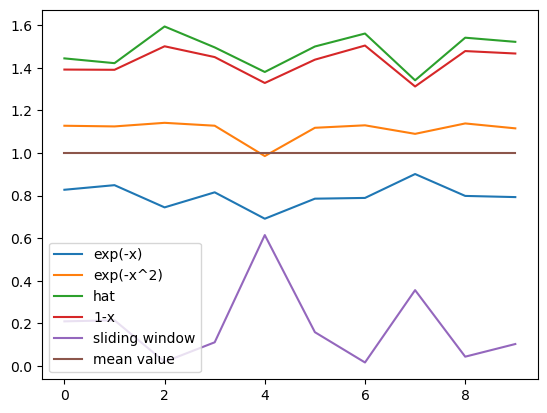

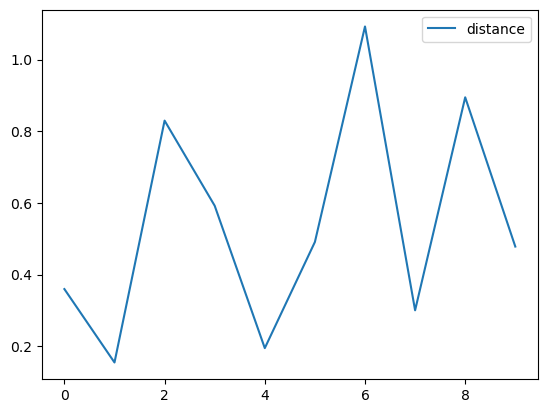

In [134]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**2, 10000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 100, 100 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

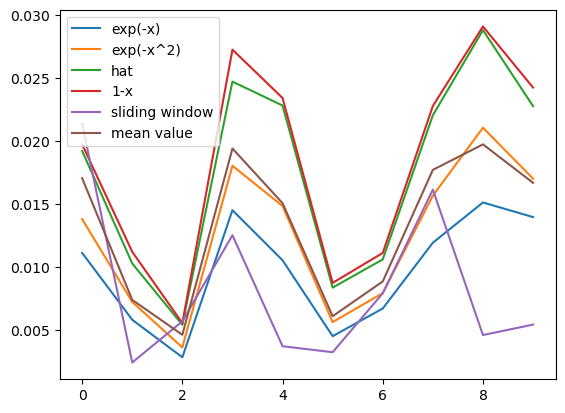

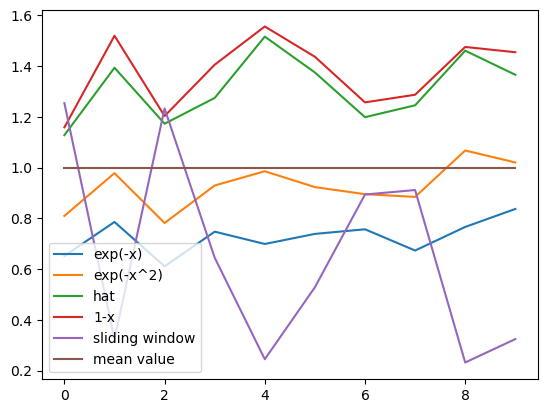

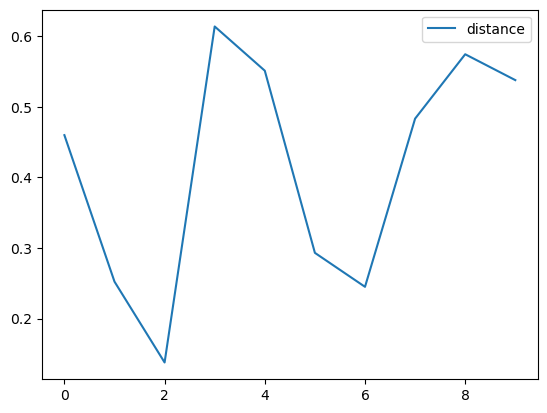

In [135]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**(0.5), 10000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 100, 100 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.iteritems():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()